# Self Supervised Learning

This notebook demonstrates how to train a self supervised model on a collection of anndata objects and produce a "complete" checkpoint file. \
Here we are going to train the model for a short time just for demonstration. \
To reproduce the results in the paper run the scripts in the run folder. \
See documentation for more details.

## Common imports

In [1]:
# TODO remove this once the notebook is stable
# %load_ext autoreload
# %autoreload 2

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# import tissue purifier
import tissue_purifier as tp

### Download and untar the example dataset

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
data_source_path = "tissue-purifier/slideseq_testis_anndata_h5ad.tar.gz"
data_destination_path = "./slideseq_testis_anndata_h5ad.tar.gz"
data_destination_folder = "./testis_anndata"

# download data from google bucket
# tp.io.download_from_bucket(bucket_name, data_source_path, data_destination_path)

# untar the data
with tarfile.open(data_destination_path, "r:gz") as fp:
    fp.extractall(path=data_destination_folder)

# Make a list of all the h5ad files in the data_destination_folder
fname_list = []
for f in os.listdir(data_destination_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['anndata_wt1.h5ad', 'anndata_sick1.h5ad', 'anndata_wt3.h5ad', 'anndata_sick2.h5ad', 'anndata_sick3.h5ad', 'anndata_wt2.h5ad']


At this point we have a folder with six 'h5ad' files corresponding to different tissues 

### Visualize the six anndata as a sanity check

In [4]:
# read in all the anndata

anndata_list = []
for fname in fname_list:
    anndata = read_h5ad(os.path.join(data_destination_folder, fname))
    print("Loaded {}".format(fname))
    anndata_list.append(anndata)

Loaded anndata_wt1.h5ad
Loaded anndata_sick1.h5ad
Loaded anndata_wt3.h5ad
Loaded anndata_sick2.h5ad
Loaded anndata_sick3.h5ad
Loaded anndata_wt2.h5ad


Each anndata contains the gene expression of ~20K genes for ~30K cells. \
Moreover each cell has 3 annotations: 'x' and 'y' coordinates and 'cell_type' information.

In [5]:
anndata_list[0]

AnnData object with n_obs × n_vars = 31659 × 24450
    obs: 'x', 'y', 'cell_type'

Plot the cell_types in space

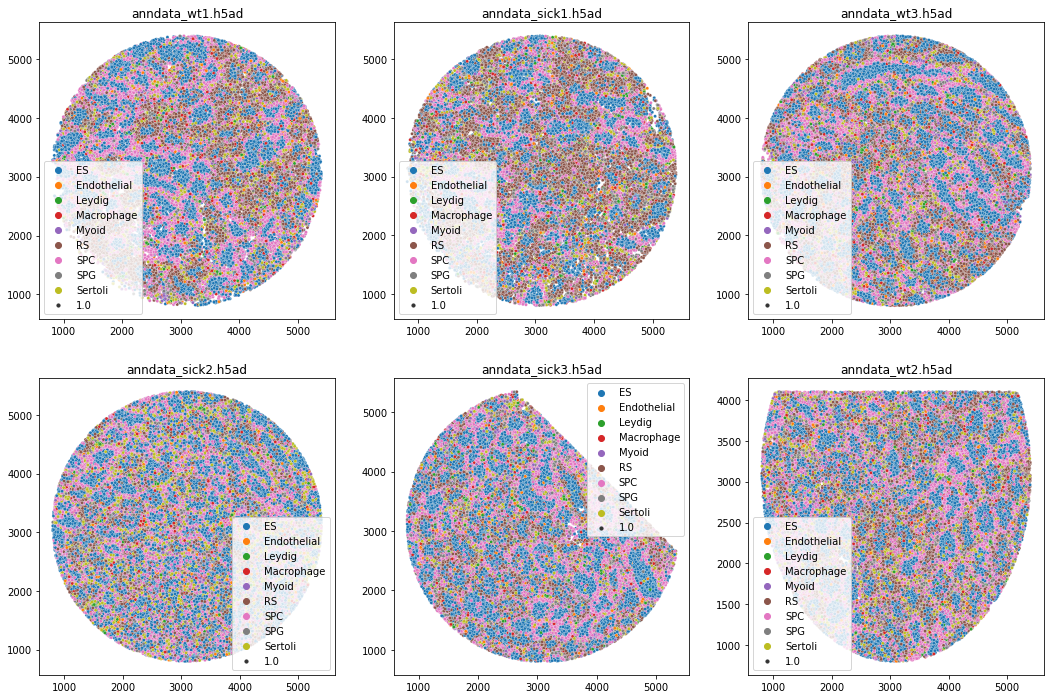

In [6]:
ncols=3
nrows=2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,6*nrows))

# Define an consistent mapping from cell_type and color for all the plots
cell_types = numpy.asarray(anndata_list[0].obs['cell_type'].values)
unique_cell_types = numpy.unique(cell_types)

n = -1
for r in range(nrows):
    for c in range(ncols):
        n += 1
        anndata_tmp = anndata_list[n]
        cell_types = numpy.asarray(anndata_tmp.obs['cell_type'].values)
        x = numpy.asarray(anndata_tmp.obs['x'].values)
        y = numpy.asarray(anndata_tmp.obs['y'].values) 
        seaborn.scatterplot(x=x, y=y, hue=cell_types, ax=axes[r,c], size=numpy.ones_like(x), sizes=(10, 10), hue_order=unique_cell_types) 
        _ = axes[r,c].set_title(fname_list[n])

Plot the cell_type counts in all the tissues 

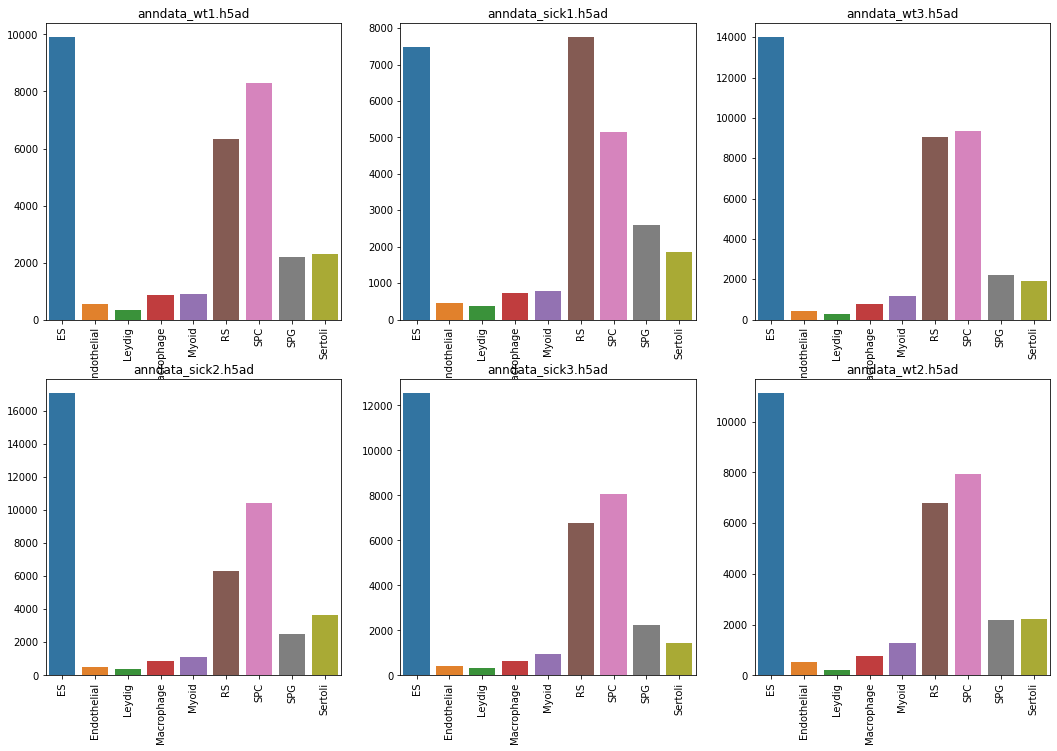

In [7]:
x_labels_rotation = 90
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,6*nrows))
n = -1
for r in range(nrows):
    for c in range(ncols):
        n += 1
        counts = anndata_list[n].obs["cell_type"].value_counts(sort=False)
        x = numpy.asarray(counts.index)
        y = counts.to_numpy()
        _ = seaborn.barplot(x=x, y=y, ax=axes[r,c])
        x_labels_raw = axes[r,c].get_xticklabels()
        axes[r,c].set_xticklabels(labels=x_labels_raw, rotation=x_labels_rotation)
        _ = axes[r,c].set_title(fname_list[n])

### Instantiate the DataModule (i.e. define train/test/val dataloader)

Here we use the defaults parameters for the datamodule and only define:
1. The mapping from cell_type to channels in the image. Each channel will represent the density of a specific cell_type. In some situation it may make sense to map multiple cell-types to the same channel. For example CD4+ and CD4- cells might be mapped to the same channel. 
2. The folder with the anndata h5ad files

In [8]:
from tissue_purifier.data import AnndataFolderDM

n_unique_cell_types = len(unique_cell_types)
categories_to_channels = dict(zip(unique_cell_types, range(n_unique_cell_types)))
print(categories_to_channels)

config_dm = tp.data.AnndataFolderDM.get_default_params() # get the defaults parameters
config_dm["root"] = data_destination_folder  # specify the folder with the anndata h5ad files
config_dm["categories_to_channels"] = categories_to_channels  # specify the mapping between cell_types and channels

dm = tp.data.AnndataFolderDM(**config_dm)

config_dm

{'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}


{'global_size': 96,
 'local_size': 64,
 'n_global_crops': 2,
 'n_local_crops': 2,
 'global_scale': [0.8, 1.0],
 'local_scale': [0.5, 0.8],
 'global_intensity': [0.8, 1.2],
 'n_element_min_for_crop': 200,
 'dropouts': [0.1, 0.2, 0.3],
 'rasterize_sigmas': [1.0, 1.5],
 'occlusion_fraction': [0.1, 0.3],
 'drop_channel_prob': 0.2,
 'drop_channel_relative_freq': None,
 'n_crops_for_tissue_train': 50,
 'n_crops_for_tissue_test': 50,
 'batch_size_per_gpu': 64,
 'data_folder': './',
 'pixel_size': 4.0,
 'x_key': 'x',
 'y_key': 'y',
 'category_key': 'cell_type',
 'categories_to_channels': {'ES': 0,
  'Endothelial': 1,
  'Leydig': 2,
  'Macrophage': 3,
  'Myoid': 4,
  'RS': 5,
  'SPC': 6,
  'SPG': 7,
  'Sertoli': 8},
 'metadata_to_classify': None,
 'metadata_to_regress': None,
 'num_workers': 16,
 'gpus': None,
 'n_neighbours_moran': 6,
 'root': './testis_anndata'}

### Instantiate the Model

Here we use the Barlow but the same apporach works for Dino, Vae, Simclr

We use the defaults parameters and only change the number of input channels of the image. 

In [9]:
from tissue_purifier.models import Barlow
# from tissue_purifier.models import Simclr
# from tissue_purifier.models import Dino
# from tissue_purifier.models import Vae

config_model = tp.models.Barlow.get_default_params()  # get the default parameters
config_model['image_in_ch'] = dm.ch_in  # specify the number of input channels consistently with datamodule
config_model

# DO NOT DO THIS
# model = tp.models.Barlow(**config_model)  
# This will work but the resulting checkpoint will not include the configuration of the datamodule and the 
# resulting ckpt file will be "incomplete".

# DO THIS INSTEAD
config_model.update(config_dm)  # concatenate the two configuration dictionaries
model = tp.models.Barlow(**config_model)  
# Now the checkpoint contains the full information to reproduce the simulation.
# To reproduce the results in the paper you need to use the config.yaml file provided.

### Train the model and save the final checkpoint

In [10]:
import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from tissue_purifier.models import NeptuneLoggerCkpt

In [11]:
pl.seed_everything(seed=0, workers=True)

Global seed set to 0


0

We use Neptune to log our results. \
Here Neptune is run in the 'offline' mode and the logs are written to local disk. \
Neptune can run in 'async' mode and the results will be saved on a remote database with a nice graphic interface. \
For the 'async' option to work you need to sign up for a free account and provide the correct project and api_key. \
See https://docs.neptune.ai/ for more info.

In [12]:
pl_neptune_logger = NeptuneLoggerCkpt(
    api_key="ANONYMOUS",  # replace with your own
    project='cellarium/tissue-purifier', # replace with your own
    run=None,  # if None a new run will be logged. If the run is provided the result will be appended to existing run  
    log_model_checkpoints=True, 
    mode="offline",  # "async"
    tags=["test"],
    fail_on_exception=True,  
)

# Save the checkpoint periodically during training
ckpt_train = ModelCheckpoint(
    save_weights_only=False,
    save_on_train_epoch_end=True,
    save_last=True,
    every_n_epochs=3,
)
    
# Define the trainer
pl_trainer = Trainer(
    weights_save_path="saved_ckpt",
    callbacks=[ckpt_train],
    gpus=torch.cuda.device_count(),  # number of gpu cards on a single machine to use
    check_val_every_n_epoch=10,
    num_sanity_val_steps=0,
    max_epochs=1, #config_model["max_epochs"],  # run for a single epoch
    logger=pl_neptune_logger,
    log_every_n_steps=100,
    sync_batchnorm=True,
)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


offline/993f4a60-b974-4a4c-a1af-8f1f88ddb23b
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
pl_trainer.fit(model=model, datamodule=dm)

reading file ./adata_before_subset.h5ad
number of elements ---> 28983
mean and median spacing 15.923758030297261, 15.499200173476508
The dense shape of the image is -> torch.Size([9, 1178, 1174])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 28981     1]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 28977     3]
reading file ./adata_1.h5ad
number of elements ---> 33059
mean and median spacing 15.358030584634598, 15.508166323067783
The dense shape of the image is -> torch.Size([9, 1180, 855])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 33033    13]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 32973    43]
reading file ./adata_0.h5ad
number of elements ---> 31659
mean and median spacing 15.622264926052864, 15.420071793081707
The dense shape of the image is -> torch.Size([9, 1178, 1178])
Occupacy (zero, single, double, .


  | Name       | Type        | Params
-------------------------------------------
0 | backbone   | Sequential  | 21.3 M
1 | projection | Sequential  | 9.4 M 
2 | bn_final   | BatchNorm1d | 0     
-------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.903   Total estimated model params size (MB)


All cat_to_codes dictionaries are identical {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
created train_dataset device = cpu, length = 18
created test_dataset device = cpu, length = 450


/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory saved_ckpt/offline-name/OFFLINE-1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:406: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training

Training: 0it [00:00, ?it/s]

/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 9. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


### Save the final checkpoint. 

Since the model was instantiate using a dictionary containing all the parameters (both for model and datamodule) the checkpoint is complete. \
A single checkpoint file contains all the information needded to reproduce the simulation.   

In [14]:
pl_trainer.save_checkpoint("ckpt_barlow.pt")  

### Visualize the crops used for training  as a sanity check

In [15]:
from tissue_purifier.plots import show_raw_all_channels, show_raw_one_channel

In [16]:
train_loader = dm.train_dataloader()  # get the train_dataloader from the datamodule
batch = next(iter(train_loader))  # get one batch from the dataloader
list_sp_imgs, list_labels, list_metadata = batch  # batch consists of 3 lists: sparse_images, labels, metadata

In [17]:
n_examples = 5  # number of distinct crops
n_augmentations = 3  # apply the random data augmentation this many times

all_imgs = []
for n in range(n_augmentations):
    imgs_tmp = dm.trsfm_train_global(list_sp_imgs[:n_examples])  # apply the data augmentations
    all_imgs.append(imgs_tmp)
    
imgs_train = torch.cat(all_imgs, dim=0)
print("imgs_train.shape ->", imgs_train.shape)

imgs_train.shape -> torch.Size([15, 9, 96, 96])


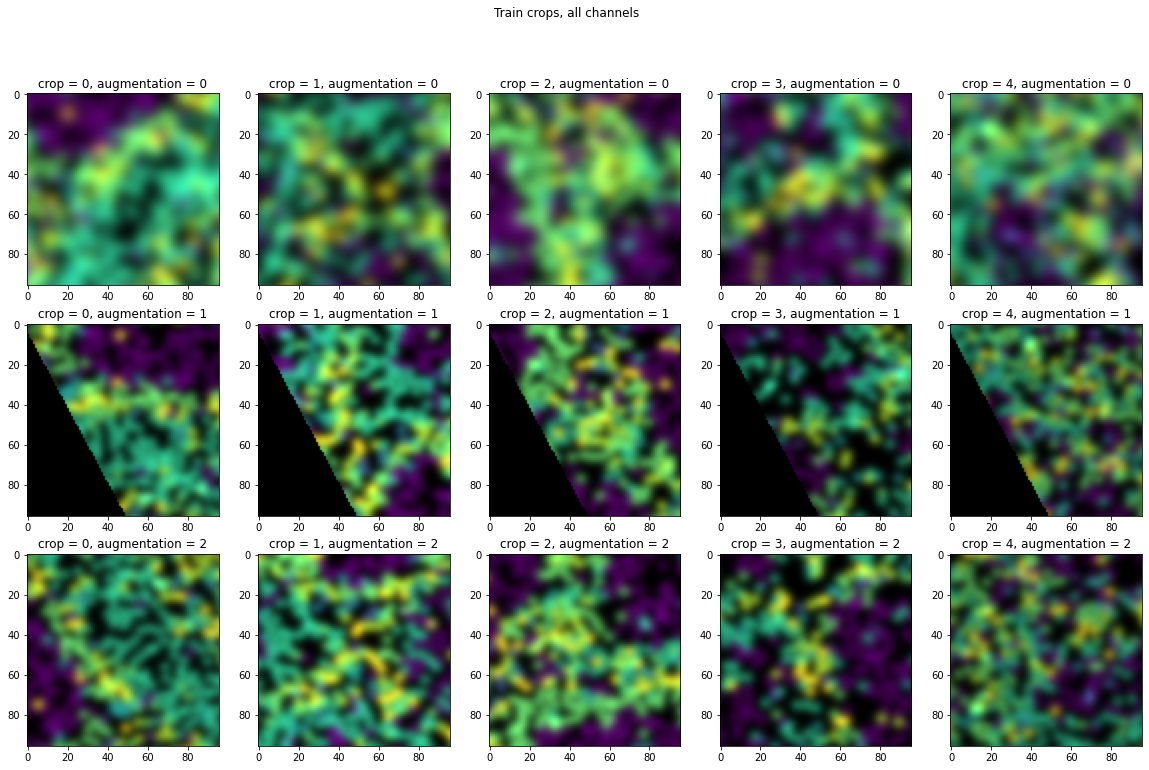

In [18]:
# Each column is a different patch
# Each row is a different instance of the random data-augmentation

titles = []
for r in range(n_augmentations):
    for c in range(n_examples):
        titles.append("crop = {}, augmentation = {}".format(c,r))

train_all_ch_fig = show_raw_all_channels(imgs_train, 
                                         cmap="viridis", 
                                         n_col=n_examples, 
                                         figsize=(4*n_examples, 4*n_augmentations), 
                                         sup_title="Train crops, all channels",
                                        titles=titles)
train_all_ch_fig

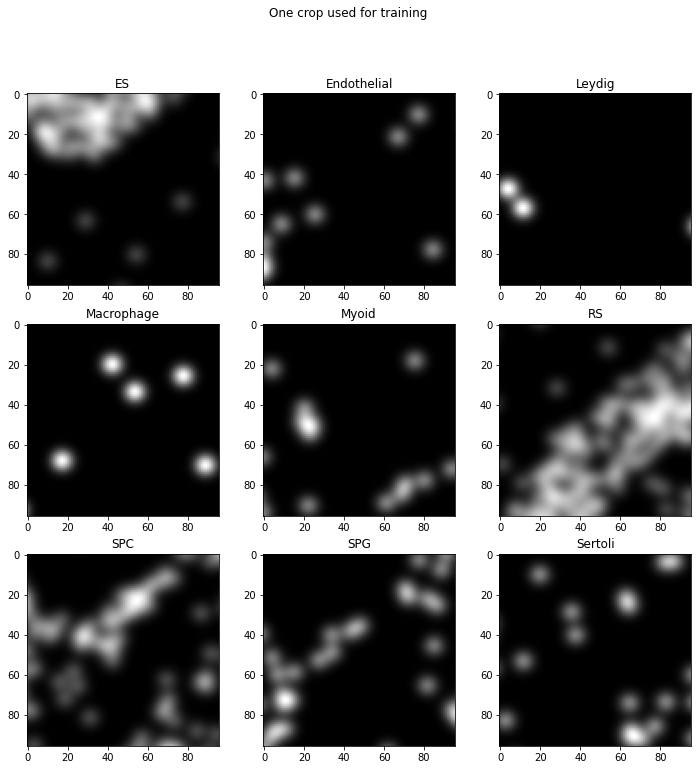

In [19]:
train_one_ch_fig = show_raw_one_channel(imgs_train[0], 
                                        n_col=3,  
                                        sup_title="One crop used for training",
                                        titles=list(unique_cell_types))
train_one_ch_fig